In [1]:
import os
import random

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

/Users/rafael.goncalves/Documents/personal/cnn/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

train_dir = 'data/train'
test_dir = 'data/test'
val_dir = 'data/valid'

#classes to be used
classes = ['football', 'formula 1 racing', 'nascar racing', 'baseball', 'hockey', 'basketball',
           'olympic wrestling', 'rugby', 'canoe slamon', 'roller derby', 'high jump',
           'rollerblade racing', 'field hockey', 'figure skating women', 'golf', 'polo',
           'rings', 'swimming', 'uneven bars', 'figure skating pairs']

Num GPUs Available:  0


In [5]:
import math

def load_data(data_dir, batch_size, img_size):
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
    )
    
    data_flow = datagen.flow_from_directory(
        data_dir,
        class_mode="categorical",
        target_size=img_size,
        batch_size=batch_size,
        shuffle=True,
        seed=42,
        classes=classes
    )
    
    dataset = tf.data.Dataset.from_generator(
        lambda: data_flow,
        output_types=(tf.float32, tf.float32),
        output_shapes=([None, *img_size, 3], [None, len(classes)])
    )
    
    return dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE), math.ceil(data_flow.samples / batch_size)

img_size = (150, 150)

In [6]:
train_dataset, steps_per_epoch = load_data(train_dir, batch_size=64, img_size=img_size)
val_dataset, validation_steps = load_data(val_dir, batch_size=64, img_size=img_size)
test_dataset, test_steps = load_data(test_dir, batch_size=64, img_size=img_size)

Found 3147 images belonging to 20 classes.
Found 95 images belonging to 20 classes.
Found 95 images belonging to 20 classes.


<h1 style="background-color:#C2B4B9;color:white;text-align: center;padding-top: 5px;padding-bottom: 5px;border-radius: 15px 50px;">
<strong><centre>Model Training</centre></strong></h1>

### custom_cnn_it_04

----

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

model = Sequential([
    Input(shape=(150, 150, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(512, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),  # Added L2 regularization
    Dropout(0.5),
    Dense(len(classes), activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    elif epoch < 15:
        return lr * 0.9
    elif epoch < 20:
        return lr * 0.8
    else:
        return lr * 0.7

lr_scheduler = LearningRateScheduler(scheduler)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'best_model_it_04.keras',
    monitor='val_loss',
    save_best_only=True
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 15, 15, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 5, 5, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 5, 5, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │        10,260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,631,892 (10.04 MB)

 Trainable params: 2,629,908 (10.03 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [8]:
history = model.fit(
    train_dataset,
    epochs=25,
    validation_data=val_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stopping, model_checkpoint, lr_scheduler]
)

Epoch 1/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 706ms/step - accuracy: 0.1459 - loss: 4.8570 - val_accuracy: 0.0632 - val_loss: 4.7613 - learning_rate: 5.0000e-04
Epoch 2/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 39s 781ms/step - accuracy: 0.2614 - loss: 3.3629 - val_accuracy: 0.1158 - val_loss: 3.7392 - learning_rate: 5.0000e-04
Epoch 3/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 46s 922ms/step - accuracy: 0.2972 - loss: 3.0998 - val_accuracy: 0.2947 - val_loss: 3.0646 - learning_rate: 5.0000e-04
Epoch 4/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 46s 918ms/step - accuracy: 0.3244 - loss: 2.9972 - val_accuracy: 0.4105 - val_loss: 2.9081 - learning_rate: 5.0000e-04
Epoch 5/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 46s 926ms/step - accuracy: 0.3650 - loss: 2.8679 - val_accuracy: 0.4526 - val_loss: 2.6482 - learning_rate: 5.0000e-04
Epoch 6/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 38s 757ms/step - accuracy: 0.3684 - loss: 2.8129 - val_accuracy: 0.4947 - val_loss: 2.5723 - learning_rate: 5.0000e-04
Epoch 7/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 36s 712ms/step - acc

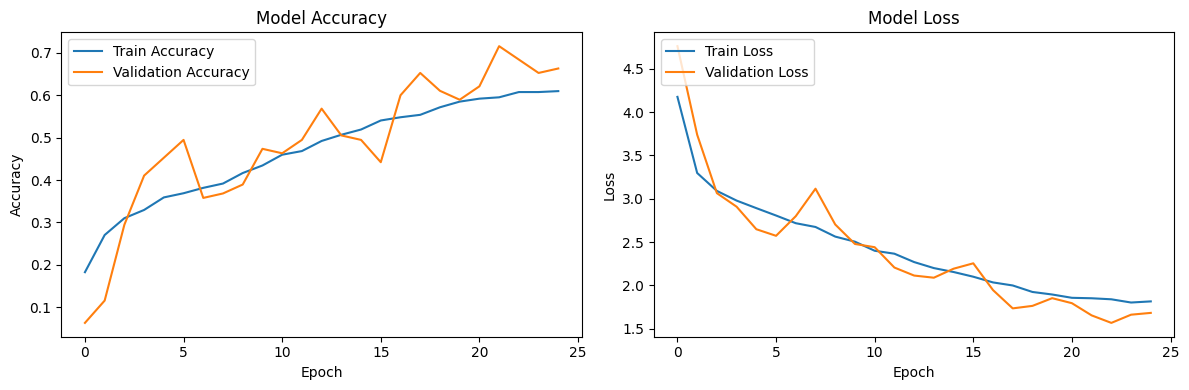

In [11]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot training & validation accuracy values
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(loc='upper left')

    # Plot training & validation loss values
    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [10]:
# test_loss, test_accuracy = model.evaluate(test_dataset, steps=test_steps)
# print(f"Test accuracy: {test_accuracy * 100:.2f}%")
# print(f"Test loss: {test_loss:.4f}")
#model.save('final_model_it_04.keras')